# **LSTM Autoencoder 기반 클러스터링을 이용한 시계열 표준 패턴 추출 (2)**

### 창원대 전자공학과 20145234 황주효 (Hwang Ju-hyo, Department of Electronic Engineering, Changwon University)
---

과정은 다음과 같다.
1. 기준 패턴 설정 및 유사 패턴 추출
2. LSTM Autoencoder 모델링 및 학습
3. T-SNE 및 UMAP 압축 및 시각화 비교
4. k-memoids 클러스터링 및 표준 패턴 플로팅 및 DTW K-memoids 클러스터링과 비교

## **2. LSTM Autoencoder 모델링 및 학습**
---

* 두개의 모델을 생성한다.
    1. LSTM 오토인코더 학습을 위한 모델
    2. 오토인코더의 인코더 부분을 위한 모델

In [60]:
timesteps = 34
n_features = 1

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import tensorflow as tf
# define model

visible = Input(shape = (timesteps, n_features))
encoder = LSTM(100, activation = 'relu', return_sequences = True)(visible)
encoder = LSTM(15, activation = 'relu')(encoder)

decoder = RepeatVector(timesteps)(encoder)
decoder = LSTM(15, activation='relu', return_sequences=True)(decoder)
decoder = LSTM(100, activation='relu', return_sequences=True)(decoder)
decoder = TimeDistributed(Dense(n_features))(decoder)

op = tf.keras.optimizers.Adam(lr = 0.001)
model = Model(inputs=visible, outputs = decoder)
model.compile(optimizer = op, loss = 'mse')
model.summary()

model2 = Model(inputs=model.inputs, outputs=model.layers[2].output)
model2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 34, 1)]           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 34, 100)           40800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 15)                6960      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 34, 15)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 34, 15)            1860      
_________________________________________________________________
lstm_15 (LSTM)               (None, 34, 100)           46400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 34, 1)             101 

* 텐서보드와 체크포인트 저장을 위한 콜백 정의

In [61]:
from datetime import datetime
import os
from tensorflow import keras

logdir="logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_path = 'ck/training/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
filepath = checkpoint_path,
verbose = 0,
save_weights_only= True,
period = 10)

* 데이터 불러오기 및 학습

In [62]:
import pickle

with open("data.pickle","rb") as fr:
    X = pickle.load(fr)

np.random.seed(77)
np.random.shuffle(X)

In [63]:
history = model.fit(X, X, epochs = 500, batch_size = 16, callbacks=[tensorboard_callback, cp_callback])

Epoch 1/500
38/38 [==============================] - 8s 129ms/step - loss: 0.0506
Epoch 2/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0209
Epoch 3/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0194
Epoch 4/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0185
Epoch 5/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0180
Epoch 6/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0176
Epoch 7/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0175
Epoch 8/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0168
Epoch 9/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0158
Epoch 10/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0162
Epoch 11/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0195
Epoch 12/500
38/38 [==============================] - 1s 19ms/step - loss: 0.0183
Epoch 13/500
38/38 [====

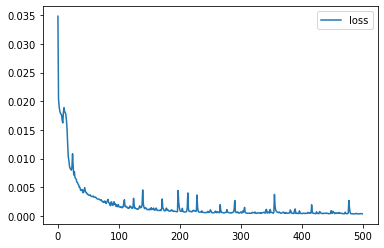

In [64]:
import matplotlib.pyplot as plt
plt.plot(range(500),history.history['loss'], label = 'loss')
plt.legend()
plt.show()

* 원데이터를 얼마나 잘 재현하는지 확인

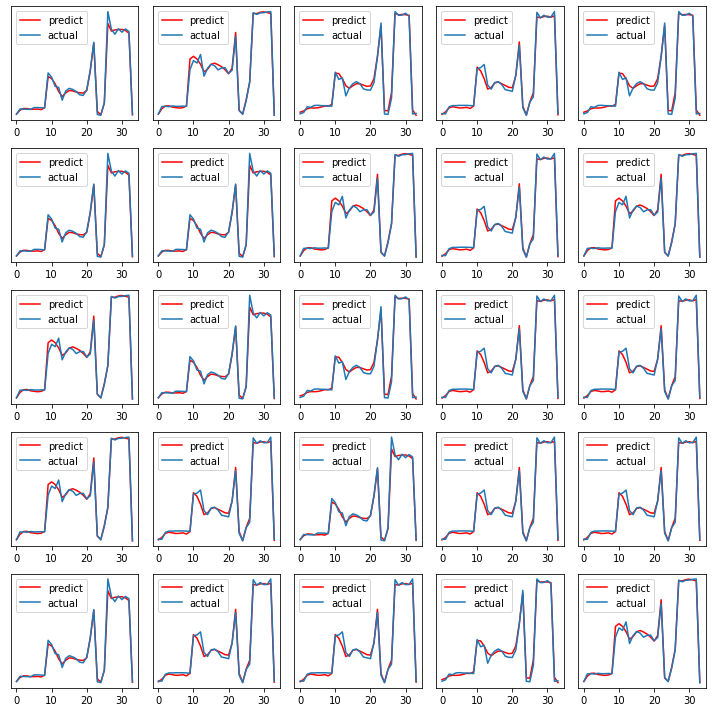

In [78]:
for s in range(0, 1):
    fig, axes = plt.subplots(5, 5, figsize = (10, 10))
    for y in range(0, 5):
        for x in range(0, 5):
            n = np.random.choice(4)
            axes[y][x].plot(model.predict(X[n].reshape(1, 34, 1)).reshape(34, 1), 'r-', label = 'predict')
            axes[y][x].plot(X[n], label = 'actual')
            axes[y][x].yaxis.set_visible(False)
            axes[y][x].legend()
            
    s = s+1
   
    plt.tight_layout()

* Encoder의 출력을 확인해본다.

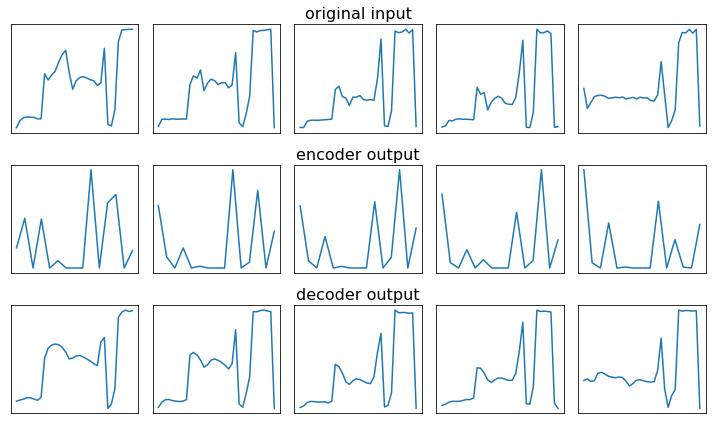

In [66]:
import pandas as pd
fig, ax = plt.subplots(3, 5, figsize = (10, 6))

for i in range(5):
    n = np.random.choice(100)
    
    ax[0][i].plot(range(34), X[n])
    ax[0][i].yaxis.set_visible(False)
    ax[0][i].xaxis.set_visible(False)
    ax[0][2].set_title('original input', {'fontsize' : 16})
    
    ax[1][i].plot(range(15),model2.predict(X)[n])
    ax[1][i].yaxis.set_visible(False)
    ax[1][i].xaxis.set_visible(False)
    ax[1][2].set_title('encoder output', {'fontsize' : 16})
    
    ax[2][i].plot(range(34),model.predict(X)[n])
    ax[2][i].yaxis.set_visible(False)
    ax[2][i].xaxis.set_visible(False)
    ax[2][2].set_title('decoder output', {'fontsize' : 16})
    
plt.tight_layout()

In [74]:
# 모델 저장
model.save('lstm_autoencoder.h5')
model2.save('lstm_encoder.h5')